<a href="https://colab.research.google.com/github/tolerant-code/T2I-Using-GAN/blob/main/T2I_Using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Library**

In [ ]:
import os
import json
import matplotlib
import numpy as np
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Concatenate, Reshape, Conv2D, Conv2DTranspose, Dropout

# **Load Dataset Directory**

In [ ]:
# Define the paths
image_dir = "/content/drive/MyDrive/Masters Thesis/TestData/image"
caption_dir = "/content/drive/MyDrive/Masters Thesis/TestData/Captions"

# **Preprocess Data**

In [ ]:
# Define image dimensions
img_width, img_height, channels = 64, 64, 3
# Create lists to store images and corresponding captions
images = []
all_captions = []

# Iterate over each image folder
for class_folder in os.listdir(image_dir):
    class_image_dir = os.path.join(image_dir, class_folder)
    class_caption_dir = os.path.join(caption_dir, class_folder)

    # Iterate through each image file in the class folder
    for image_filename in os.listdir(class_image_dir):
        # Check if the file is an image
        if image_filename.endswith(('.jpg', '.jpeg', '.png')):
            # Load image
            image_path = os.path.join(class_image_dir, image_filename)
            image = load_img(image_path, target_size=(img_width, img_height))
            image = img_to_array(image)
            images.append(image)

            # Extract image name without extension
            image_name = os.path.splitext(image_filename)[0]

            # Find corresponding caption file
            caption_filename = image_name + ".txt"
            caption_path = os.path.join(class_caption_dir, caption_filename)
            # Read captions if caption file exists
            if os.path.exists(caption_path):
                with open(caption_path, "r", encoding="utf-8") as file:
                    captions = file.read().strip().split('\n')
                    all_captions.append(captions)
            else:
                print("No caption file found for", image_filename)
                images.pop()  # Remove the image if no caption file is found

# Convert the lists to NumPy arrays
images = np.array(images)
all_captions = np.array(all_captions)

# Tokenize the captions
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(all_captions.ravel())
caption_tokens = [tokenizer.texts_to_sequences(captions) for captions in all_captions]

# Pad the caption tokens to a fixed length
max_caption_length = max(len(seq) for captions in caption_tokens for seq in captions)
caption_tokens = [pad_sequences(captions, maxlen=max_caption_length, padding='post') for captions in caption_tokens]
caption_tokens = np.array(caption_tokens)

# Create the Embedding layer
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_caption_length)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(caption_tokens, images, test_size=0.2, random_state=42)
# Continue with the rest of your GAN implementation
print(X_train.shape)
print(y_train.shape)

(2215, 10, 90)
(2215, 64, 64, 3)


# **Define The Generator Model**

In [ ]:
def build_generator(embedding_dim):
    # Input layer for the random noise
    noise_input = Input(shape=(100,))

    # Dense layer to map the noise to a higher dimensional space
    dense = Dense(256 * 8 * 8)(noise_input)
    dense = Reshape((8, 8, 256))(dense)
    # Transposed convolutional layers to upsample the image
    generator = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(dense)
    generator = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(generator)
    generator = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same')(generator)
    # Output layer with 3 channels for RGB image
    generator_output = Conv2D(channels, kernel_size=3, activation='tanh', padding='same')(generator)
    # Model
    generator_model = Model(inputs=noise_input, outputs=generator_output)
    return generator_model

# **Define The Discriminator Model**

In [ ]:
def build_discriminator(img_shape):
    # Input layer for the image
    image_input = Input(shape=img_shape)

    # Convolutional layers
    discriminator = Conv2D(32, kernel_size=3, strides=2, padding='same')(image_input)
    discriminator = Dropout(0.5)(discriminator)
    discriminator = Conv2D(64, kernel_size=3, strides=2, padding='same')(discriminator)
    discriminator = Dropout(0.5)(discriminator)
    discriminator = Conv2D(128, kernel_size=3, strides=2, padding='same')(discriminator)
    discriminator = Dropout(0.5)(discriminator)

    # Flatten the output and add a dense layer
    discriminator = Flatten()(discriminator)
    discriminator_output = Dense(1, activation='sigmoid')(discriminator)

    # Model
    discriminator_model = Model(inputs=image_input, outputs=discriminator_output)

    return discriminator_model


# **Defining The Generator and Discriminator models**

In [ ]:
generator = build_generator(embedding_dim)
discriminator = build_discriminator((img_width, img_height, channels))

# Compile Discriminator
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

# The Discriminator should not be trainable during the GAN training
discriminator.trainable = False

# Input for the GAN model (noise)
gan_input = Input(shape=(100,))
generated_image = generator(gan_input)

# Output of the GAN model
gan_output = discriminator(generated_image)

# GAN model
gan_model = Model(gan_input, gan_output)
gan_model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# **Generator Model Summary**

In [ ]:
print("Generator Model:")
generator.summary()

Generator Model:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 16384)             1654784   
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       524416    
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 64)        131136    
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 

# **Discriminator Model Summary**

In [ ]:
print("\nDiscriminator Model:")
discriminator.summary()


Discriminator Model:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 dropout_2 (Dropout)         (None, 8

# **Training The GAN Model**

In [ ]:
# Set up training parameters
epochs =200
batch_size = 64

# Initialize lists to store discriminator and generator losses during training
d_losses = []
g_losses = []

import cv2
import numpy as np

# Training loop
for epoch in range(epochs):
    # Train the discriminator
    noise = np.random.normal(0, 1, size=(batch_size, 100))
    generated_images = generator.predict(noise)
    real_images = images[np.random.randint(0, images.shape[0], batch_size)]

    resized_real_images = []
    for image in real_images:
        if len(image.shape) < 3:  # Check if the image is grayscale
            image = np.stack((image,) * 3, axis=-1)  # Convert grayscale to RGB by stacking channels

        # Normalize pixel values to the range [0, 1]
        image = image.astype(np.float32) / 255.0

        # Resize real images to (64, 64)
        resized_image = cv2.resize(image, (64, 64))
        resized_real_images.append(resized_image)

    real_images_resized = np.array(resized_real_images)

    labels_real = np.ones((batch_size, 1))
    labels_fake = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images_resized, labels_real)
    d_loss_fake = discriminator.train_on_batch(generated_images, labels_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train the generator
    noise = np.random.normal(0, 1, size=(batch_size, 100))
    labels_gan = np.ones((batch_size, 1))
    g_loss = gan_model.train_on_batch(noise, labels_gan)

    # Append discriminator and generator losses to the lists
    d_losses.append(d_loss[0])  # assuming d_loss is a tuple (loss, accuracy)
    g_losses.append(g_loss)

    # Print progress
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

2/2 [==============================] - 0s 161ms/step
Epoch 0, D Loss: 0.7427312433719635, G Loss: 0.6946380138397217
2/2 [==============================] - 0s 161ms/step
Epoch 20, D Loss: 0.7666224837303162, G Loss: 0.7047128081321716
2/2 [==============================] - 0s 170ms/step
Epoch 40, D Loss: 0.7379313409328461, G Loss: 0.7778161764144897
2/2 [==============================] - 0s 150ms/step
Epoch 60, D Loss: 0.7434691786766052, G Loss: 0.7303065657615662
2/2 [==============================] - 0s 162ms/step
Epoch 80, D Loss: 0.7464191019535065, G Loss: 0.6967614889144897
1/2 [==============>...............] - ETA: 0s

# **Evaluate The Generator and Discriminator Loss**

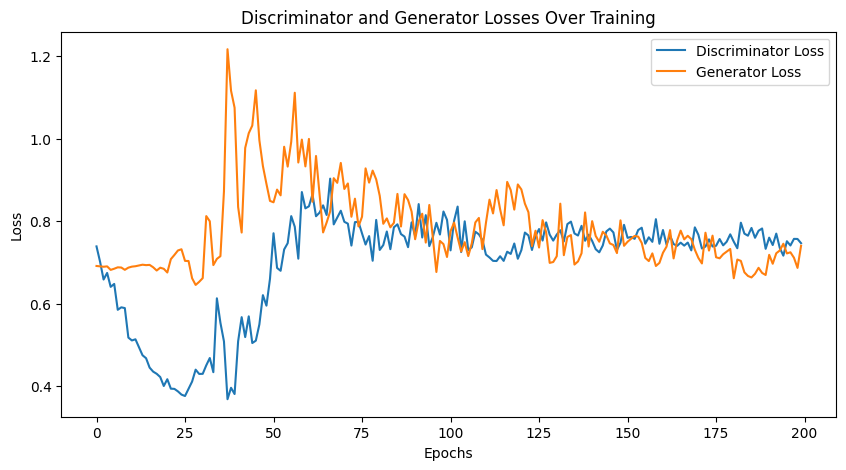

In [ ]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Discriminator and Generator Losses Over Training')
plt.show()

# **Generate Image from New Text**

In [ ]:
# Example: Convert Amharic text to embeddings
amharic_text = ["ይህ ወፍ ሙሉ በሙሉ ጥቁር ናት, ምንቃር ወፍራም እና ትንሽ ኩርባዎች ይወርዳሉ"]
amharic_sequences = tokenizer.texts_to_sequences(amharic_text)

# Define max_caption_length or replace it with a specific value
max_caption_length = 20  # Example value, adjust according to your needs

# Pad sequences
amharic_padded = pad_sequences(amharic_sequences, padding='post', maxlen=max_caption_length)

# Ensure the shape is compatible with the generator input
amharic_embeddings = np.random.normal(0, 1, size=(len(amharic_text), 100))  # Adjust the size to match the generator input


1/1 [==============================] - 0s 34ms/step


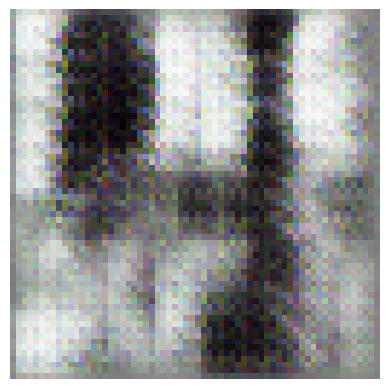

In [ ]:
# Generate images from Amharic text embeddings
generated_images = generator.predict(amharic_embeddings)

# Display the generated images
import matplotlib.pyplot as plt

# Assuming you want to display the first generated image
generated_image = generated_images[0]  # Assuming there's only one generated image

# Rescale the image from (-1, 1) to (0, 1) for display
generated_image = (generated_image + 1) / 2.0

# Show the image
plt.imshow(generated_image)
plt.axis('off')
plt.show()


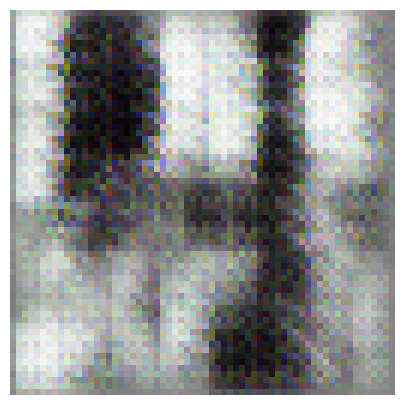

In [ ]:
import matplotlib.pyplot as plt

def plot_generated_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(5, 5))
    axs = np.ravel(axs)
    for i, img in enumerate(images):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.show()

# Rescale images to 0-1 range for visualization
generated_images_rescaled = 0.5 * generated_images + 0.5

plot_generated_images(generated_images_rescaled)


# **The End**